# 01_Analysis of Bureau Dataset
In this notebook I analyze the bureau dataset which is described below:

- Client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan there are as many rows as number of credits the client had in Credit Bureau before the application date.

**Analysis Summary**:
    After analyzing the bureau dataset I created a vector for each loan id with following columns:

    - COUNT_GROUP: The number of accounts by bin size of 5( i.e. 1 means 0 to 5 accounts).
    - OVERDUE: Flag to indicate if a client has an overdue account.
    - DEBT_OVER_50%: Account group with credit limit 50% or higher.
    - DEBT_OVER_75%: Account group with credit limit higher 75% or higher.
    - DEBT_OVER_100%: Account group with credit limit higher 100% or higher.
    - ACTIVE: The number of active accounts by id group by bin size of 5.
    - CLOSED: The number of closed accounts by id group by bin size of 5.
    - ADVERSE: The number of adverse (bad debt or sold) accounts by id group by bin size of 5.
    - CREDIT_TYPE_COUNT: The number of different types accounts by id group.
I also created an aggregate table of four functions ('minimum', 'maximum', 'mean','standard deviation' SK_ID_CURR for each of the availble float64 fields. Each field would have a new column for each of the functions. This created a total of 48 features. By taking this approach I figure there will be many fields available during model selection that can be removed if there feature importance is zero.

In [1]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

## 1.1 Import table and overview data

In [2]:
# Import tables
bureau = pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\bureau.csv")
FieldsNames = pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\HomeCredit_columns_description.csv")

In [3]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [4]:
# # print description of each field in the table
Info = FieldsNames[FieldsNames['Table'] == 'bureau.csv'] [['Row','Description']]
for i in Info.values.tolist():
    print (i,"\n", "-"*100)

['SK_ID_CURR', 'ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau '] 
 ----------------------------------------------------------------------------------------------------
['SK_BUREAU_ID', 'Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)'] 
 ----------------------------------------------------------------------------------------------------
['CREDIT_ACTIVE', 'Status of the Credit Bureau (CB) reported credits'] 
 ----------------------------------------------------------------------------------------------------
['CREDIT_CURRENCY', 'Recoded currency of the Credit Bureau credit'] 
 ----------------------------------------------------------------------------------------------------
['DAYS_CREDIT', 'How many days before current application did client apply for Credit Bureau credit'] 
 -------------------------------------------------------------------------------------

In [5]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [6]:
num_col = bureau.select_dtypes(["float", "integer"]).columns

In [7]:
bureau[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,1716428.0,2.782149e+05,1.029386e+05,100001.000,188866.75,278055.0,367426.00,4.562550e+05
SK_ID_BUREAU,1716428.0,5.924434e+06,5.322657e+05,5000000.000,5463953.75,5926303.5,6385681.25,6.843457e+06
DAYS_CREDIT,1716428.0,-1.142108e+03,7.951649e+02,-2922.000,-1666.00,-987.0,-474.00,0.000000e+00
CREDIT_DAY_OVERDUE,1716428.0,8.181666e-01,3.654443e+01,0.000,0.00,0.0,0.00,2.792000e+03
DAYS_CREDIT_ENDDATE,1610875.0,5.105174e+02,4.994220e+03,-42060.000,-1138.00,-330.0,474.00,3.119900e+04
DAYS_ENDDATE_FACT,1082775.0,-1.017437e+03,7.140106e+02,-42023.000,-1489.00,-897.0,-425.00,0.000000e+00
AMT_CREDIT_MAX_OVERDUE,591940.0,3.825418e+03,2.060316e+05,0.000,0.00,0.0,0.00,1.159872e+08
CNT_CREDIT_PROLONG,1716428.0,6.410406e-03,9.622391e-02,0.000,0.00,0.0,0.00,9.000000e+00
AMT_CREDIT_SUM,1716415.0,3.549946e+05,1.149811e+06,0.000,51300.00,125518.5,315000.00,5.850000e+08
AMT_CREDIT_SUM_DEBT,1458759.0,1.370851e+05,6.774011e+05,-4705600.320,0.00,0.0,40153.50,1.701000e+08


In [8]:
cat_col = bureau.select_dtypes(["object"]).columns

In [9]:
bureau[cat_col].describe().T

,count,unique,top,freq
CREDIT_ACTIVE,1716428,4,Closed,1079273
CREDIT_CURRENCY,1716428,4,currency 1,1715020
CREDIT_TYPE,1716428,15,Consumer credit,1251615


---------------------------------------------------------------------------------------------------- 
 CREDIT_ACTIVE


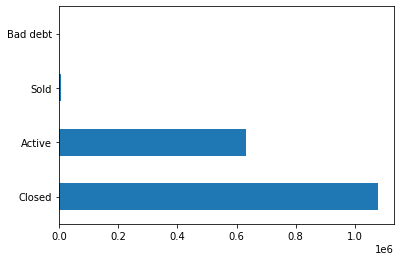

---------------------------------------------------------------------------------------------------- 
 CREDIT_CURRENCY


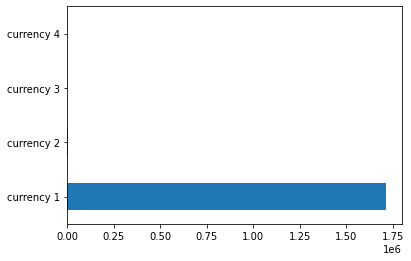

---------------------------------------------------------------------------------------------------- 
 CREDIT_TYPE


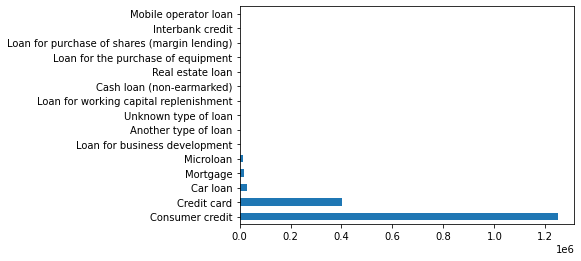

In [10]:
for i in cat_col:
    print("-"*100,"\n",i)
    bureau[i].value_counts().plot.barh()
    plt.show()

## 1.2 Add <CREDIT_ACTIVE> column
- Lets create a table that counts the number of CREDIT_ACTIVE by SK_ID_CURR.
- We can combined this table with others to create a final features table.

In [11]:
credit_active_table = pd.pivot_table(bureau,index =['SK_ID_CURR'], 
                     columns=['CREDIT_ACTIVE'],
                     values=['DAYS_CREDIT'],aggfunc='count',fill_value=0)

#let replace columns with no spaces and make upper case
cols = [c.replace(' ','_').upper() for c in credit_active_table.columns.levels[1]]
credit_active_table.columns = cols

credit_active_table.head()

,ACTIVE,BAD_DEBT,CLOSED,SOLD
SK_ID_CURR,,,,
100001,3,0,4,0
100002,2,0,6,0
100003,1,0,3,0
100004,0,0,2,0
100005,2,0,1,0


In [12]:
def make_cat(feature,df):
    """ Lets reduce the number of counts
        by grouping them into bins of 5 and setting a ceiling value.
    """ 
    df[feature]  = df[feature].apply(lambda x:int(x/5)+1) # grouping into bins of 5
    column = df[feature].value_counts(normalize=True).reset_index() 
    df[feature] = np.clip(df[feature], 1, column[column[feature]>0.01]['index'].max()) #setting ceiling value

In [13]:
#lets 'ACTIVE' into a category in bins size 5
make_cat('ACTIVE',credit_active_table)
credit_active_table.groupby(['ACTIVE']) .size()

ACTIVE
1    276932
2     28879
dtype: int64

In [14]:
#lets 'CLOSED' into a category in bins size 5
make_cat('CLOSED',credit_active_table)
credit_active_table.groupby(['CLOSED']) .size()

CLOSED
1    218588
2     68564
3     14621
4      4038
dtype: int64

In [15]:
#lets combine 'BAD_DEBT' and 'SOLD' into one field called 'ADVERSE' since by themselves they are too unbalance.
def adverse(x):
    bad = x['BAD_DEBT'] > 0
    sold = x['SOLD'] > 0
    if bad or sold:
        return 2
    else:
        return 1
    
credit_active_table['ADVERSE'] = credit_active_table.apply(adverse,axis=1).astype('int64')
credit_active_table.groupby(['ADVERSE']) .size()

ADVERSE
1    299772
2      6039
dtype: int64

In [16]:
#lets drop columns
credit_active_table.drop(['BAD_DEBT', 'SOLD'], axis=1, inplace=True)

In [17]:
#resent index
credit_active_table.reset_index(inplace=True)
credit_active_table.head()

,SK_ID_CURR,ACTIVE,CLOSED,ADVERSE
0,100001,1,1,1
1,100002,1,2,1
2,100003,1,1,1
3,100004,1,1,1
4,100005,1,1,1


## 1.3 Add Count Field
Count the number of bureau records by loan id and then create a category count group of bin size 5.

In [18]:
bureau['COUNT'] = bureau.groupby('SK_ID_CURR')['SK_ID_CURR'].transform('count')
bureau['COUNT_GROUP'] = bureau['COUNT'].apply(lambda x:int(x/5)+1)
bureau.drop('COUNT',axis=1,inplace=True)
bureau.groupby('COUNT_GROUP').size()

COUNT_GROUP
1     370880
2     682749
3     401642
4     166453
5      60091
6      20791
7       7337
8       2976
9       1241
10       890
11       519
12       450
13       121
16        78
19        94
24       116
dtype: int64

## 1.4 Add Count Orverdue Counts
Create new coulumn to count the number of accounts that are overdue.

In [19]:
def overDue(df):
    name_flag = 'OVERDUE_FLAG'
    name = 'OVERDUE'
    
    def fun(x):
        days = abs(x)
        if days > 0:
            return 1
        else:
            return 0

    df[name_flag] = df['CREDIT_DAY_OVERDUE'].apply(fun)
    
    df[name] = df.groupby('SK_ID_CURR')[name_flag].transform('sum')
    
    #lets increase the groups by 1 to make the base group 1
    df[name] = df[name].apply(lambda x:x+1)
    
    #drop column
    df.drop([name_flag],axis=1, inplace=True)

#apply function
overDue(bureau)

In [20]:
bureau.groupby(['OVERDUE']).size()

OVERDUE
1    1686759
2      26998
3       1893
4        441
5        153
6        104
7         62
8         18
dtype: int64

## 1.5 Add Count Credit Type Count
Create new column to count the number of different account credit types.

In [21]:
#groupby id and credit types
credit_size = bureau.groupby(['SK_ID_CURR','CREDIT_TYPE']).size()

#create new dataframe
df_credit_size = pd.DataFrame(data=credit_size.values,
                              index=credit_size.index,columns=['COUNT'])

df_credit_size.reset_index(inplace=True)

credit_type_size = df_credit_size.groupby('SK_ID_CURR').size() 

credit_type_count = pd.DataFrame(data=credit_type_size.values,
                              index=credit_type_size.index,
                                 columns=['CREDIT_TYPE_COUNT'])
credit_type_count.reset_index(inplace=True)
credit_type_count.head()

,SK_ID_CURR,CREDIT_TYPE_COUNT
0,100001,1
1,100002,2
2,100003,2
3,100004,1
4,100005,2


In [22]:
credit_type_count.groupby('CREDIT_TYPE_COUNT').size().head()

CREDIT_TYPE_COUNT
1    109315
2    166653
3     27652
4      2113
5        74
dtype: int64

## 1.6 Add Count High Debt Accounts
Create two new columns to count the number of high debt accounts:
- Accounts with used debt limit of 50% or higher.
- Accounts with used debt limit of 100% or higher.

In [23]:
#fill nan values
bureau[['AMT_CREDIT_SUM_DEBT']]= bureau[['AMT_CREDIT_SUM_DEBT']].fillna(0)
bureau[['AMT_CREDIT_SUM']]= bureau[['AMT_CREDIT_SUM']].fillna(0)

In [24]:
def debtPercent(x):
    '''Calculate debt percent.'''
    debt = x['AMT_CREDIT_SUM_DEBT']
    limit = x['AMT_CREDIT_SUM']
    if debt <= 0 :
        return 0
    elif limit <=0:
        return 0
    else:
        return debt/limit
    
#apply function
bureau['DEBT_PERCENT'] = bureau.apply(debtPercent,axis=1)

In [25]:
bureau['DEBT_PERCENT']

0          0.00000
1          0.76152
2          0.00000
3          0.00000
4          0.00000
            ...   
1716423    1.00000
1716424    0.00000
1716425    0.00000
1716426    0.00000
1716427    0.00000
Name: DEBT_PERCENT, Length: 1716428, dtype: float64

In [26]:
def highDebt(name,df,threshold):
    name_flag = 'HIGH_DEBT_FLAG'

    df[name_flag] = df['DEBT_PERCENT'].apply(lambda x: 1 if x >= threshold else 0)
    
    df[name] = df.groupby('SK_ID_CURR')[name_flag].transform('sum')
    
     #lets increase the groups by 1 to make the base group 1
    df[name] = df[name].apply(lambda x:x+1)
    
    #drop column
    df.drop([name_flag],axis=1, inplace=True)

In [27]:
highDebt("DEBT_OVER_50%",bureau,0.5)
highDebt("DEBT_OVER_75%",bureau,0.75)
highDebt("DEBT_OVER_100%",bureau,1.0)

## 1.7 Add Aggregation Columns

In [36]:
num_table = bureau[num_col]
num_table

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,-131,NaN
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,-20,NaN
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.50,0.0,NaN,0.0,-16,NaN
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.00,0.0,NaN,0.0,-16,NaN
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.00,0.0,NaN,0.0,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,-19,NaN
1716424,100044,5057754,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,-2493,NaN
1716425,100044,5057762,-1809,0,-1628.0,-970.0,NaN,0,15570.00,0.0,NaN,0.0,-967,NaN
1716426,246829,5057770,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,-1508,NaN


In [37]:
num_table.drop(['SK_ID_CURR','SK_ID_BUREAU'], axis=1, inplace=True)

C:\miniconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [51]:
num_table.columns

Index(['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'],
      dtype='object')

In [43]:
#let get minimum, maximum, average and standard deviation
fun_agg = ['min', 'max', 'mean','std']

In [52]:
agg_fun_df = bureau.groupby('SK_ID_CURR')[num_table.columns].agg(fun_agg)

In [54]:
#rename columns
agg_fun_df.columns = ["{}_{}".format(c[0],c[1].upper()) for c in agg_fun_df.columns.values.tolist()] 

#let fill nan values
agg_fun_df.fillna(0,inplace=True)

In [55]:
agg_fun_df.head()

,DAYS_CREDIT_MIN,DAYS_CREDIT_MAX,DAYS_CREDIT_MEAN,DAYS_CREDIT_STD,CREDIT_DAY_OVERDUE_MIN,CREDIT_DAY_OVERDUE_MAX,CREDIT_DAY_OVERDUE_MEAN,CREDIT_DAY_OVERDUE_STD,DAYS_CREDIT_ENDDATE_MIN,DAYS_CREDIT_ENDDATE_MAX,...,AMT_CREDIT_SUM_OVERDUE_MEAN,AMT_CREDIT_SUM_OVERDUE_STD,DAYS_CREDIT_UPDATE_MIN,DAYS_CREDIT_UPDATE_MAX,DAYS_CREDIT_UPDATE_MEAN,DAYS_CREDIT_UPDATE_STD,AMT_ANNUITY_MIN,AMT_ANNUITY_MAX,AMT_ANNUITY_MEAN,AMT_ANNUITY_STD
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,489.942514,0,0,0.0,0.0,-1329.0,1778.0,...,0.0,0.0,-155,-6,-93.142857,77.204120,0.0,10822.5,3545.357143,4800.607529
100002,-1437,-103,-874.000000,431.451040,0,0,0.0,0.0,-1072.0,780.0,...,0.0,0.0,-1185,-7,-499.875000,518.522472,0.0,0.0,0.000000,0.000000
100003,-2586,-606,-1400.750000,909.826128,0,0,0.0,0.0,-2434.0,1216.0,...,0.0,0.0,-2131,-43,-816.000000,908.053963,0.0,0.0,0.000000,0.000000
100004,-1326,-408,-867.000000,649.124025,0,0,0.0,0.0,-595.0,-382.0,...,0.0,0.0,-682,-382,-532.000000,212.132034,0.0,0.0,0.000000,0.000000
100005,-373,-62,-190.666667,162.297053,0,0,0.0,0.0,-128.0,1324.0,...,0.0,0.0,-121,-11,-54.333333,58.594653,0.0,4261.5,1420.500000,2460.378172


## 1.8 Combine All Datasets
Combine all the datasets get the final feature dataset.

In [83]:
features = ['COUNT_GROUP','OVERDUE','DEBT_OVER_50%','DEBT_OVER_75%','DEBT_OVER_100%']

#these features columns are same value by id so we can take the first row
reduced_dataset = bureau.groupby('SK_ID_CURR').first()[features]

reduced_dataset.reset_index(inplace=True)

In [84]:
def applyMax(feature,df):
    """ Lets set a ceiling value.
    """ 
    column = df[feature].value_counts(normalize=True).reset_index() 
    df[feature] = np.clip(df[feature], 1, column[column[feature]>0.01]['index'].max()) #setting ceiling value

In [85]:
#set max values
for i in features:
    applyMax(i,reduced_dataset)

In [73]:
reduced_dataset

,SK_ID_CURR,COUNT_GROUP,OVERDUE,DEBT_OVER_50%,DEBT_OVER_75%,DEBT_OVER_100%
0,100001,2,1,3,2,1
1,100002,2,1,2,1,1
2,100003,1,1,1,1,1
3,100004,1,1,1,1,1
4,100005,1,1,3,3,1
...,...,...,...,...,...,...
305806,456249,3,1,2,2,1
305807,456250,1,1,3,3,1
305808,456253,1,1,2,1,1
305809,456254,1,1,1,1,1


In [86]:
final_dataset = reduced_dataset.merge(credit_active_table,
                                      how='left', 
                                      on='SK_ID_CURR',
                                      validate='one_to_one')

final_dataset  = final_dataset.merge(credit_type_count,
                                      how='left', 
                                      on='SK_ID_CURR',
                                      validate='one_to_one')

final_dataset  = final_dataset.merge(agg_fun_df.reset_index(),
                                      how='left', 
                                      on='SK_ID_CURR',
                                      validate='one_to_one')

In [87]:
final_dataset.head()

,SK_ID_CURR,COUNT_GROUP,OVERDUE,DEBT_OVER_50%,DEBT_OVER_75%,DEBT_OVER_100%,ACTIVE,CLOSED,ADVERSE,CREDIT_TYPE_COUNT,...,AMT_CREDIT_SUM_OVERDUE_MEAN,AMT_CREDIT_SUM_OVERDUE_STD,DAYS_CREDIT_UPDATE_MIN,DAYS_CREDIT_UPDATE_MAX,DAYS_CREDIT_UPDATE_MEAN,DAYS_CREDIT_UPDATE_STD,AMT_ANNUITY_MIN,AMT_ANNUITY_MAX,AMT_ANNUITY_MEAN,AMT_ANNUITY_STD
0,100001,2,1,3,2,1,1,1,1,1,...,0.0,0.0,-155,-6,-93.142857,77.204120,0.0,10822.5,3545.357143,4800.607529
1,100002,2,1,2,1,1,1,2,1,2,...,0.0,0.0,-1185,-7,-499.875000,518.522472,0.0,0.0,0.000000,0.000000
2,100003,1,1,1,1,1,1,1,1,2,...,0.0,0.0,-2131,-43,-816.000000,908.053963,0.0,0.0,0.000000,0.000000
3,100004,1,1,1,1,1,1,1,1,1,...,0.0,0.0,-682,-382,-532.000000,212.132034,0.0,0.0,0.000000,0.000000
4,100005,1,1,3,3,1,1,1,1,2,...,0.0,0.0,-121,-11,-54.333333,58.594653,0.0,4261.5,1420.500000,2460.378172


## 1.9 Save Final Dataset

In [88]:

# rename columns  append all fields with 'BUREAU_' except id field

col_name = []
for c in final_dataset.columns:
    if c =='SK_ID_CURR':
        col_name.append(c)
    else:
        col_name.append("BUREAU_"+c)

final_dataset.columns = col_name

In [89]:
final_dataset.head()

,SK_ID_CURR,BUREAU_COUNT_GROUP,BUREAU_OVERDUE,BUREAU_DEBT_OVER_50%,BUREAU_DEBT_OVER_75%,BUREAU_DEBT_OVER_100%,BUREAU_ACTIVE,BUREAU_CLOSED,BUREAU_ADVERSE,BUREAU_CREDIT_TYPE_COUNT,...,BUREAU_AMT_CREDIT_SUM_OVERDUE_MEAN,BUREAU_AMT_CREDIT_SUM_OVERDUE_STD,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_STD,BUREAU_AMT_ANNUITY_MIN,BUREAU_AMT_ANNUITY_MAX,BUREAU_AMT_ANNUITY_MEAN,BUREAU_AMT_ANNUITY_STD
0,100001,2,1,3,2,1,1,1,1,1,...,0.0,0.0,-155,-6,-93.142857,77.204120,0.0,10822.5,3545.357143,4800.607529
1,100002,2,1,2,1,1,1,2,1,2,...,0.0,0.0,-1185,-7,-499.875000,518.522472,0.0,0.0,0.000000,0.000000
2,100003,1,1,1,1,1,1,1,1,2,...,0.0,0.0,-2131,-43,-816.000000,908.053963,0.0,0.0,0.000000,0.000000
3,100004,1,1,1,1,1,1,1,1,1,...,0.0,0.0,-682,-382,-532.000000,212.132034,0.0,0.0,0.000000,0.000000
4,100005,1,1,3,3,1,1,1,1,2,...,0.0,0.0,-121,-11,-54.333333,58.594653,0.0,4261.5,1420.500000,2460.378172


In [91]:
final_dataset.to_csv(r'C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\1_1_bureau.csv',index=False)
print("File was saved.")

File was saved.
